- [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
- Code: [ndb's Generative Adversarial Nets](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/GAN_for_MNIST_Tutorial.ipynb)

In [1]:
# import time

import numpy as np

# for data
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch import normal

# model
from torch.cuda import FloatTensor
from torch.nn import Module, Sequential, Linear, BatchNorm1d, Sigmoid, LeakyReLU, Tanh, BCELoss
from torch.optim import Adam

import matplotlib.pyplot as plt
from torchvision.utils import save_image

### data

In [2]:
transform_train = Compose([
    Resize(28),
    ToTensor(),
    Normalize([0.5], [0.5])
])

전처린 거 같은데, torch 공부하려면 tensor 연산 전 후 나눠서 공부해야 겠네.

In [3]:
train_dataset = MNIST(root="./data", train=True, download=False, transform=transform_train)

X:\Program Files\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

## model

In [5]:
latent_dim = 100

### Generator

In [6]:
class Generator(Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [Linear(input_dim, output_dim)]
            if normalize:
                layers.append(BatchNorm1d(output_dim, 0.8))
            layers.append(LeakyReLU(0.2, inplace=True))
            return layers

        self.model = Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            Linear(1024, 1 * 28 * 28),
            Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

### Discriminator

In [7]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = Sequential(
            Linear(1 * 28 * 28, 512),
            LeakyReLU(0.2, inplace=True),
            Linear(512, 256),
            LeakyReLU(0.2, inplace=True),
            Linear(256, 1),
            Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)
        return output

### Connect

In [8]:
lr = 0.0002

In [9]:
generator = Generator()
generator.cuda()
optimizer_G = Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [10]:
discriminator = Discriminator()
discriminator.cuda()
optimizer_D = Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
adversarial_loss = BCELoss()
# Binary Cross Entropy
adversarial_loss.cuda()

BCELoss()

## train

In [12]:
n_epochs = 200
sample_interval = 2000
# start_time = time.time()
history = {"d_loss": [], "g_loss": []}

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.cuda()

        real = FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = FloatTensor(imgs.size(0), 1).fill_(0.0)

        # ? Generator learn
        optimizer_G.zero_grad()
        # gradient descent를 이용하기 전에 parameter buffer 값을 0으로 초기화하는 듯한 작업
        # > autograd의 추적기록을 피하기 위해 학습 가능한 매개변수를 갖는 Tensor를 직접 0으로 조작하여 모델의 가중치를 갱신할 때 사용한다.
        # 아예 history tracking을 하지 않으려면 torch.no_grad()를 이용한다.

        z = normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated = generator(z)
        g_loss = adversarial_loss(discriminator(generated), real)

        # parameter udpate after calculation of back-propagation
        g_loss.backward()
        optimizer_G.step()

        # ? Discriminator learn
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            save_image(generated.data[:25], f"{done}.png", nrow=5, norrmalize=True)

    history["d_loss"].append(d_loss)
    history["g_loss"].append(g_loss)
    print(f"[Epoch {epoch:3d}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")

[Epoch   0/200] [D loss: 0.497175] [G loss: 0.625260]
[Epoch   1/200] [D loss: 0.361471] [G loss: 1.554101]
[Epoch   2/200] [D loss: 0.379129] [G loss: 1.118365]
[Epoch   3/200] [D loss: 0.282575] [G loss: 1.019792]
[Epoch   4/200] [D loss: 0.224965] [G loss: 1.889806]
[Epoch   5/200] [D loss: 0.203131] [G loss: 1.756845]
[Epoch   6/200] [D loss: 0.387102] [G loss: 0.960950]
[Epoch   7/200] [D loss: 0.252450] [G loss: 1.812878]
[Epoch   8/200] [D loss: 0.376844] [G loss: 1.573439]
[Epoch   9/200] [D loss: 0.265335] [G loss: 1.434571]
[Epoch  10/200] [D loss: 0.183607] [G loss: 1.660473]
[Epoch  11/200] [D loss: 0.245278] [G loss: 1.142408]
[Epoch  12/200] [D loss: 0.295012] [G loss: 1.467185]
[Epoch  13/200] [D loss: 0.504950] [G loss: 0.665888]
[Epoch  14/200] [D loss: 0.249229] [G loss: 2.373088]
[Epoch  15/200] [D loss: 0.266148] [G loss: 1.305344]
[Epoch  16/200] [D loss: 0.247318] [G loss: 1.269084]
[Epoch  17/200] [D loss: 0.298759] [G loss: 1.716876]
[Epoch  18/200] [D loss: 0.1

## drawing

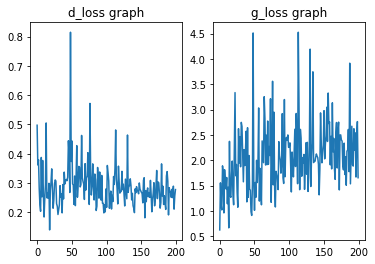

In [13]:
f, ax = plt.subplots(1, 2, figsize=(10, 6))

x_len = np.arange(len(history["d_loss"]))
for idx, label in enumerate(["d_loss", "g_loss"]):
    ax[idx].plot(x_len, history[label])
    ax[idx].set_title(label + " graph")

plt.show()

이거 안정화 덜 된 것 같은데..? 생성자 loss 증가하는 거 같은데?